# Problème de Bandits

In [83]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Chargement des données

In [15]:
def loadData(filename="CTR.txt"):
    f = open(filename, 'r')
    x = []
    y = []
    for l in f.readlines():
        l = l.split(':')
        x.append(l[1].split(';'))
        y.append(l[2].split(';'))
    return np.array(x,float), np.array(y,float)    

In [16]:
features, CTR = loadData()
print (features) #dimension : 5000 x 5
print (CTR) #dimension : 5000 x 10

[[ 0.74837091  0.83520778  0.07669896  0.17243899  0.14344585]
 [ 0.16841852  0.13375446  0.43486407  0.99567796  0.04879988]
 [ 0.48528732  0.56698869  0.04165727  0.96255958  0.18507967]
 ..., 
 [ 0.90672498  0.26443308  0.68915888  0.7947705   0.61931101]
 [ 0.36209241  0.71064341  0.02028564  0.29490415  0.00365891]
 [ 0.75866876  0.49570435  0.11383344  0.33930558  0.87186044]]
[[ 0.10341906  0.19069778  0.         ...,  0.          0.          0.07857372]
 [ 0.          0.          0.         ...,  0.          0.14654765
   0.32459556]
 [ 0.10957461  0.13662645  0.         ...,  0.          0.01475992
   0.19367686]
 ..., 
 [ 0.          0.08915825  0.         ...,  0.          0.          0.34631266]
 [ 0.04174618  0.24481708  0.         ...,  0.          0.07438058
   0.20063039]
 [ 0.          0.11570582  0.         ...,  0.12383718  0.          0.14313359]]


## Baselines

### Stratégie Random

In [50]:
# A chaque itération, on choisit n'importe quel annonceur
def strategieRandom(CTR):
    return np.random.randint(0, CTR.shape[1], CTR.shape[0])

print (strategieRandom(CTR))

[2 7 2 ..., 8 1 8]


### Stratégie StaticBest

In [51]:
# A chaque itération, on choisit l'annonceur avec le meilleur taux de clics cumulés
def strategieStaticBest(CTR):
    meilleur = list(CTR.sum(0)).index(max(CTR.sum(0))) # l'indice du meilleur taux de clics cumulés
    return np.ones((len(CTR)), int) * meilleur 

print (strategieStaticBest(CTR))

[3 3 3 ..., 3 3 3]


### Stratégie Optimale

In [53]:
#A chaque iteration, on choisit l'annonceur qui a le meilleur taux de clics à cette itération
def strategieOptimale(CTR):
    return CTR.argmax(1)

print (strategieOptimale(CTR))

[6 9 9 ..., 3 1 3]


## UCB

In [75]:
def UCB(CTR):
    politiques = np.zeros((CTR.shape[0]), int)
    reward = np.zeros((CTR.shape[1]))
    nbrSelection = np.ones((CTR.shape[1])) 
    mu = np.zeros((CTR.shape[1]))   # recompense moyenne jusqu'a present
    for t in range(0,CTR.shape[0]):
        b = mu + np.sqrt(2 * np.log(t+1) / nbrSelection) 
        politiques[t] = b.argmax()   
        reward[politiques[t]] += CTR[t][politiques[t]]
        nbrSelection[politiques[t]] += 1
        mu[politiques[t]] = reward[politiques[t]] / (nbrSelection[politiques[t]] * 1.0)
    return politiques


print (UCB(CTR))

[0 1 2 ..., 3 3 3]


## LinUCB
### UCB avec prise en compte individuelle du contexte

In [68]:
def LinUCB(features, CTR, alpha):
    d = features.shape[1] # dimension
    politiques = np.zeros((CTR.shape[0]), int)
    A = np.eye(d).reshape(1,d,d).repeat(CTR.shape[1],axis=0) # 10 matrice d'identite
    b = np.zeros((CTR.shape[1], d)) # dimension 10 x 5
    theta = np.zeros((CTR.shape[1], d)) # dimension 10 x 5
    p = np.zeros((CTR.shape[1])) # dimension 10
    for i in range(0,features.shape[0]):
        for a in range(CTR.shape[1]):
            inverseA = np.linalg.inv(A[a])
            theta[a] = np.dot(b[a], inverseA)
            p[a] = np.dot(features[i], theta[a].T) + alpha * np.sqrt(np.dot(features[i], np.dot(inverseA, features[i].T)))
            # recompense
        politiques[i] = np.where(p == p.max())[0][0]
        A[politiques[i]] += np.dot(features[i].T, features[i])
        b[politiques[i]] += CTR[i][politiques[i]] * features[i]
    return politiques

print (LinUCB(features, CTR, 0.5))

[0 1 2 ..., 9 9 3]


## Evaluation

In [79]:
def evaluation(politiques, CTR):
    reward = np.zeros((CTR.shape[0]))
    regret = np.zeros((CTR.shape[0]))
    for i in range(CTR.shape[0]):
        reward[i] = CTR[i][politiques[i]]
        regret[i] = CTR[i].max() - reward[i]
    return reward, regret

# Experimentation

In [80]:
randomCTR = strategieRandom(CTR)
staticBestCTR = strategieStaticBest(CTR)
optimaleCTR = strategieOptimale(CTR)

In [81]:
ucbCTR = UCB(CTR)
linucbCTR = LinUCB(features, CTR, 0.5)

rewardRandom, regretRandom = evaluation(randomCTR, CTR)
rewardStaticBest, regretStaticBest = evaluation(staticBestCTR, CTR)
rewardOptimale, regretOptimale = evaluation(optimaleCTR, CTR)
rewardUCB, regretUCB = evaluation(ucbCTR, CTR)
rewardLinUCB, regretLinUCB = evaluation(linucbCTR, CTR)

## Courbes de reward et Courbes de regret

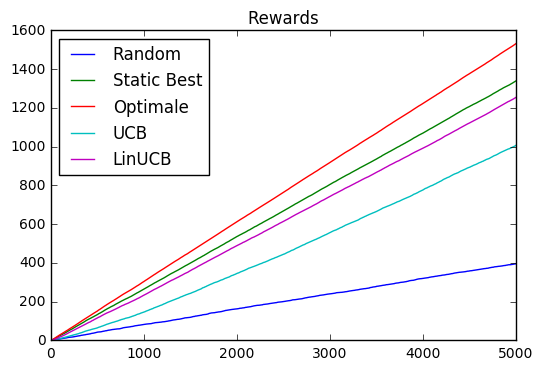

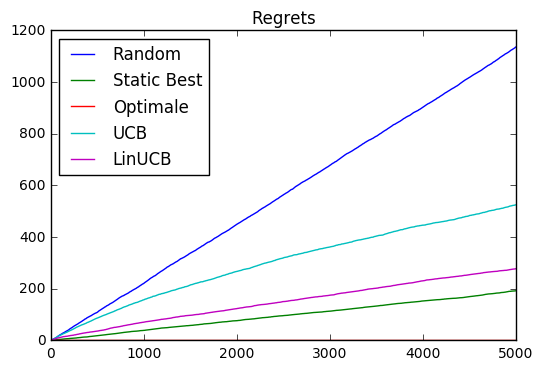

In [84]:
x = range(len(CTR))

plt.plot(x, rewardRandom.cumsum())
plt.plot(x, rewardStaticBest.cumsum())
plt.plot(x, rewardOptimale.cumsum())
plt.plot(x, rewardUCB.cumsum())
plt.plot(x, rewardLinUCB.cumsum())
plt.title('Rewards')
plt.legend(['Random','Static Best','Optimale','UCB','LinUCB'],loc='upper left')
plt.show()

plt.plot(x, regretRandom.cumsum())
plt.plot(x, regretStaticBest.cumsum())
plt.plot(x, regretOptimale.cumsum())
plt.plot(x, regretUCB.cumsum())
plt.plot(x, regretLinUCB.cumsum())
plt.title('Regrets')
plt.legend(['Random','Static Best','Optimale','UCB','LinUCB'],loc='upper left')
plt.show()